# Classification of Citrus Leaves with ResNet50
The data is downloaded from [this site](https://data.mendeley.com/datasets/3f83gxmv57/2).

## Custom Dataloader
As the dataset is not included in PyTorch's dataset API, a custom dataset and dataloader can be created from [these instructions](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
).

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image # use PyTorch to read images
import torchvision.transforms as transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# constants
IMG_DIR = "./data_citrus_leaves/"
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
NUM_EPOCHS = 40
IMAGE_SIZE = (256, 256)
LR = 0.001
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

Here, `RESNET_MEAN` and `RESNET_STD` refer to the mean and standard deviation of the images used to train the ResNet50 model respectively.

In [3]:
# simple encoder to convert `string` to `int`
encoder = {
    "healthy" : 0,
    "black_spot" : 1,
    "canker" : 2,
    "greening" : 3,
    "healthy" : 4,
    "melanose" : 5
}

decoder = {
    0 : "healthy",
    1 : "black_spot",
    2 : "canker",
    3 : "greening",
    4 : "healthy",
    5 : "melanose"
}

# class label is name of sub directory, images are in sub directory
class CitrusLeavesDataset(Dataset):
    def __init__(self, img_dir, transform = None, target_transform = None):
        # define main directory of images and transformations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # store paths and labels in DataFrame
        data = { "image_path" : [], "label" : [] }
        for sub_dir in os.listdir(img_dir):
            for file in os.listdir(os.path.join(img_dir, sub_dir)):
                data['image_path'].append(os.path.join(img_dir, sub_dir, file))
                data['label'].append(sub_dir)

        # store in annotations
        self.annotations = pd.DataFrame(data)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image path and label
        image = read_image(self.annotations.iloc[idx, 0]).float()
        label = encoder[self.annotations.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

`torchvisions.transforms` can be used directly on a PyTorch tensor!

In [4]:
# transform for training
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD)
])

# inverse transform for plotting
inverse_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in RESNET_STD]),
    transforms.Normalize(mean = [-m for m in RESNET_MEAN], std = [1., 1., 1.]),
])

data = CitrusLeavesDataset(img_dir = IMG_DIR, transform = transform)

# split data into train and test
train_data, test_data = random_split(
    data,
    [
        int(len(data) * TRAIN_PROPORTION),            # n% of data
        len(data) - int(len(data) * TRAIN_PROPORTION) # rest of data
    ]
)

# create data loaders
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Understanding the Data

In [6]:
# information on dataset
class_names = data.annotations['label'].unique()
print("Classes:", class_names)
print("Length of dataset:", len(data))

Classes: ['black_spot' 'canker' 'greening' 'healthy' 'melanose']
Length of dataset: 609


The dataset contains $609$ images of citrus leaves. The images are in PNG format and have size $256\times256$.

There are five classes: `black_spot`, `canker`, `greening`, `healthy`, and `melanose`.

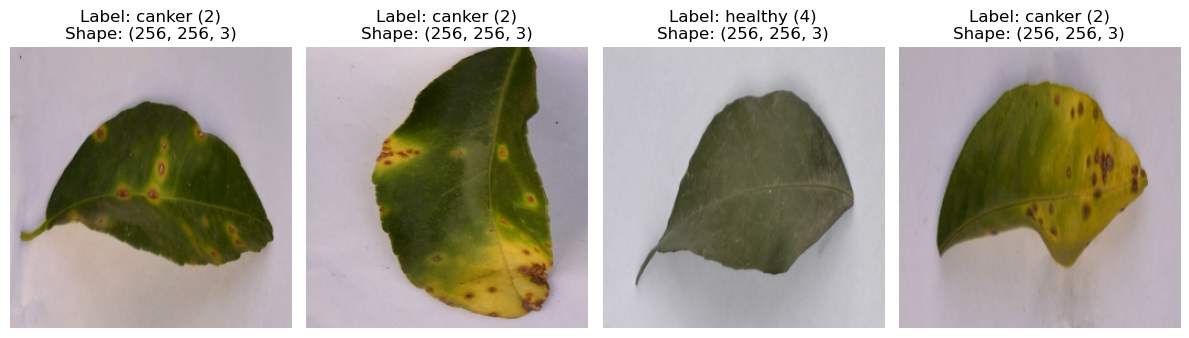

In [7]:
# show random sample images
fig, axes = plt.subplots(1, 4, figsize = (12, 5))
for i in range(4):
    # inverse transform and rearrange dimensions (convert to int32 to avoid overflow)
    image, label = data[np.random.randint(0, len(data))]
    image = inverse_transform(image).numpy().astype(np.int32).transpose(1, 2, 0)

    # show image
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title("Label: {} ({})\nShape: {}".format(decoder[label], label, image.shape))
plt.tight_layout()
plt.show()

## Preparing the Model

In [8]:
# ResNet50 model
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained = True)

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# create feature extraction model
feature_extractor = nn.Sequential(*list(model.children())[:-1]) # exclude last layer
print("Shape of feature extractor portion:", feature_extractor(torch.rand(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])).shape)

Shape of feature extractor portion: torch.Size([1, 2048, 1, 1])


In [10]:
# create model
model = nn.Sequential(
    feature_extractor,
    nn.Flatten(),
    nn.Linear(2048, 6), # 6 classes
).to(device)

In [11]:
# define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

## Training the Model

In [12]:
losses = []
for e in range(NUM_EPOCHS):
    # training
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # move to device
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # print statistics
        if i % 8 == 0:
            print("[{}, {}] Loss: {}".format(e + 1, i, loss.item()))

[1, 0] Loss: 1.8711251020431519
[1, 8] Loss: 0.384011447429657
[2, 0] Loss: 0.21445082128047943
[2, 8] Loss: 0.29067039489746094
[3, 0] Loss: 0.2777417004108429
[3, 8] Loss: 0.15214116871356964
[4, 0] Loss: 0.9374489784240723
[4, 8] Loss: 0.24264439940452576
[5, 0] Loss: 0.10733279585838318
[5, 8] Loss: 0.38978680968284607
[6, 0] Loss: 0.25738948583602905
[6, 8] Loss: 0.25433114171028137
[7, 0] Loss: 0.19543036818504333
[7, 8] Loss: 0.42407193779945374
[8, 0] Loss: 0.14951667189598083
[8, 8] Loss: 0.36590325832366943
[9, 0] Loss: 0.17146426439285278
[9, 8] Loss: 0.29075419902801514
[10, 0] Loss: 0.08523273468017578
[10, 8] Loss: 0.3276212215423584
[11, 0] Loss: 0.24379311501979828
[11, 8] Loss: 0.17028073966503143
[12, 0] Loss: 0.12550808489322662
[12, 8] Loss: 0.11501694470643997
[13, 0] Loss: 0.2624216079711914
[13, 8] Loss: 0.13315808773040771
[14, 0] Loss: 0.04828668013215065
[14, 8] Loss: 0.0867827832698822
[15, 0] Loss: 0.1185898631811142
[15, 8] Loss: 0.12520332634449005
[16, 0]

Each `images` variable has size $32\times3\times256\times256$.

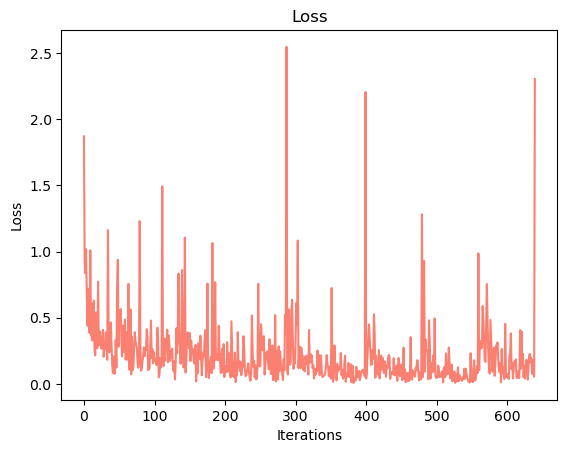

In [17]:
plt.plot(losses, c = "salmon")
plt.title("Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

## Making Predictions

In [18]:
# store predictions
predictions = torch.tensor([], dtype = torch.long).to(device)
true = torch.tensor([], dtype = torch.long).to(device)

correct = 0
total = 0
model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        # move to device
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions = torch.cat((predictions, predicted))
        true = torch.cat((true, labels))

        # calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

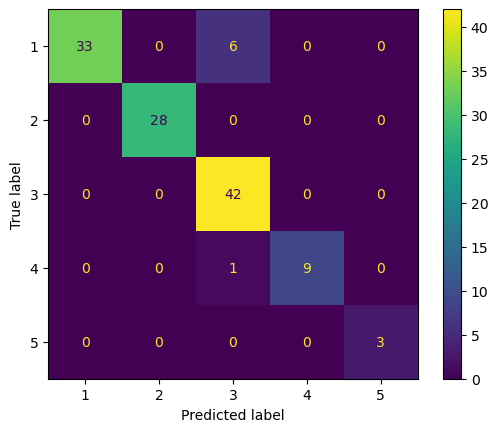

In [19]:
matrix = metrics.ConfusionMatrixDisplay.from_predictions(true.cpu().numpy(), predictions.cpu().numpy())

In [22]:
print(
    "Accuracy:",
    round(metrics.accuracy_score(true.cpu().numpy(), predictions.cpu().numpy()), 3),
    round(correct / total, 3)
)

Accuracy: 0.943 0.943


In [23]:
print("Unique labels:", true.unique())
auc_scores = []
for i in range(1, 6):
    label_trues = true.cpu().numpy() == i
    label_predicts = predictions.cpu().numpy() == i

    auc_score = metrics.roc_auc_score(label_trues, label_predicts)
    print("\tAUC for label {} ({}): {}".format(
        decoder[i], i,
        auc_score
    ))
    auc_scores.append(auc_score)

print("Average AUC:", np.mean(auc_scores))

Unique labels: tensor([1, 2, 3, 4, 5], device='cuda:0')
	AUC for label black_spot (1): 0.9230769230769231
	AUC for label canker (2): 1.0
	AUC for label greening (3): 0.9562499999999999
	AUC for label healthy (4): 0.95
	AUC for label melanose (5): 1.0
Average AUC: 0.9658653846153846


Image No.: 6


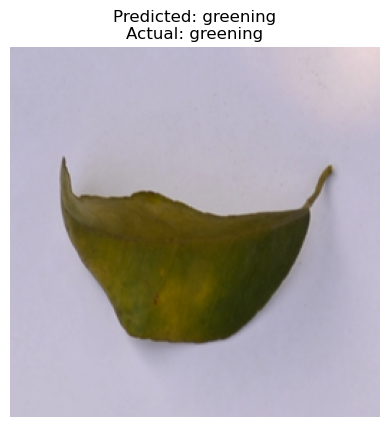

In [24]:
# select random image
idx = np.random.randint(0, len(test_data))
sample_image = test_data[idx][0]
sample_label = test_data[idx][1]
print("Image No.:", idx)

# add another dimension to input
with torch.no_grad():
    sample_predict = model(sample_image[None, :, :, :].to(device))
    _, sample_predict = torch.max(sample_predict.data, 1)

plt.imshow(inverse_transform(sample_image).numpy().astype(np.int32).transpose(1, 2, 0))
plt.title("Predicted: {}\nActual: {}".format(decoder[sample_predict.item()], decoder[sample_label]))
plt.axis("off")
plt.show()